## Adapter trimming and barcode demultiplexing with Porechop

Some ONT applications can gain advantage of pooling (multiplexing) different samples by using sequence adapters to reduce the costs of the sequencing run. As a consequence, the results of the run will be a mixture of reads with different adapters tagging each sample. NanoDJ relies on [Porechop](https://github.com/rrwick/Porechop) for finding and trimming ONT adapters and demultiplexing the barcoded ONT reads. Porechop commands and options are shown in the command usage:

In [1]:
!porechop -h

usage: porechop -i INPUT [-o OUTPUT]
                [--format {auto,fasta,fastq,fasta.gz,fastq.gz}] [-v VERBOSITY]
                [-t THREADS] [-b BARCODE_DIR]
                [--barcode_threshold BARCODE_THRESHOLD]
                [--barcode_diff BARCODE_DIFF] [--require_two_barcodes]
                [--untrimmed] [--discard_unassigned]
                [--adapter_threshold ADAPTER_THRESHOLD]
                [--check_reads CHECK_READS] [--scoring_scheme SCORING_SCHEME]
                [--end_size END_SIZE] [--min_trim_size MIN_TRIM_SIZE]
                [--extra_end_trim EXTRA_END_TRIM]
                [--end_threshold END_THRESHOLD] [--no_split]
                [--discard_middle] [--middle_threshold MIDDLE_THRESHOLD]
                [--extra_middle_trim_good_side EXTRA_MIDDLE_TRIM_GOOD_SIDE]
                [--extra_middle_trim_bad_side EXTRA_MIDDLE_TRIM_BAD_SIDE]
                [--min_split_read_size MIN_SPLIT_READ_SIZE] [-h] [--version]

Porechop: a tool for finding adapters in O

Basic Porechop command requires an input file (**-i** option) and output filename (after the '**>**' symbol). Porechop finds the adapters and places the trimmed reads on the output.

Demultiplexing can be done with the **-b BARCODE_DIR** option instead of defining the output file for trimmed reads. Reads are distributed in different bins (files) depending on their barcodes and these files are placed on BARCODE_DIR directory. The user can also control the minimum match percentage of barcodes changing the threshold (**--barcode_threshold**) and add more options as shown on Porechop usage page.

The demultiplexing task can be in Albacore since 1.0 version. In this case, it is frequent to find that both algorithms disagree on the most appropriate bin for a read. Porechop can perform its own demultiplexing on the Albacore output, placing the reads in which both software disagree in a bin called 'none'.


In [2]:
!cd data && mkdir porechop && cd porechop && wget https://github.com/rrwick/Porechop/files/901044/1_out.fastq.zip && gzip -S .zip -d 1_out.fastq.zip
!porechop -i data/porechop/1_out.fastq -b data/porechop/demultiplexed --threads 2


Loading reads
data/porechop/1_out.fastq
4,001 reads loaded


Looking for known adapter sets
4,001 / 4,001 (100.0%)

Barcodes determined to be in forward orientation
                                        Best               
                                        read       Best    
                                        start      read end
  Set                                   %ID        %ID     
  SQK-NSK007                                96.6       77.3
  Rapid                                    100.0        0.0
  RBK004_upstream                           78.0        0.0
  SQK-MAP006                                80.0       79.2
  SQK-MAP006 short                          76.9       76.9
  PCR adapters 1                            78.3       79.2
  PCR adapters 2                            79.2       79.2
  PCR adapters 3                            79.2       80.0
  1D^2 part 1                               74.2       74.1
  1D^2 part 2                               97.0      

The following builds a plot that shows the run yield for each barcode. The x and y axes show the total number of reads and the total number of bases, repectively. The size of each point corresponds to the average read length of the reads for that specific barcode.

In [3]:
#!/usr/bin/python

import sys
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from Bio import SeqIO

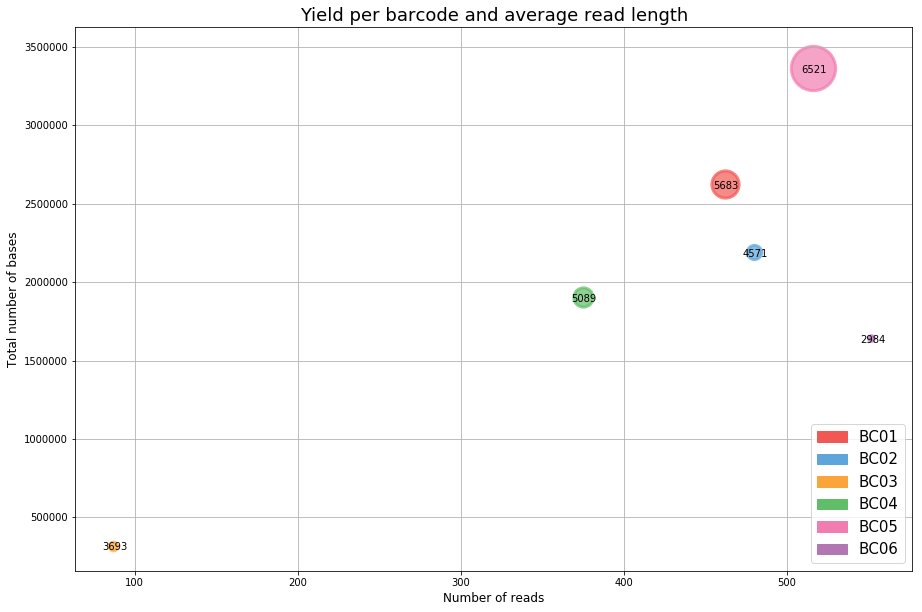

In [4]:
matplotlib.rcParams['figure.figsize'] = (15, 10)

barcode_dir = 'data/porechop/demultiplexed/'
#Modify this list with an element per barcode (6 in the example)
barcode_files = ['BC01', 'BC02', 'BC03', 'BC04', 'BC05', 'BC06']

avg_lenghts = []
bases_cnt = []
read_cnt = []

#Bin files parser
def read_bin(filename):
    read_lenghts = []
    count = 0
    for seq_record in SeqIO.parse(filename, 'fastq'):
        read_lenghts.append(len(seq_record.seq))
        count += 1

    avg_lenghts.append(sum(read_lenghts)/len(read_lenghts))
    bases_cnt.append(sum(read_lenghts))
    read_cnt.append(count)

for bin_file in barcode_files:
    read_bin(barcode_dir + str(bin_file) + '.fastq')

#One colour per barcode (6 + none colour in the example)
colors = ['#F15854', '#5DA5DA', '#FAA43A', '#60BD68', '#F17CB0', '#B276B2', '#DECF3F']

#Size of each point depending on the average read lengths
s = [3.2**(n/1000) for n in avg_lenghts]

#Draw the points and annotations
fig, ax = plt.subplots()
for index, barcode in enumerate(barcode_files, start=0):
    ax.scatter(read_cnt[index],bases_cnt[index],s=s[index],c=colors[index],label=barcode, alpha=0.7, linewidth=3)
    ax.annotate(int(avg_lenghts[index]), (read_cnt[index] - 7,bases_cnt[index] - 10**4.5))

#Legend
handles = [mpatches.Patch(color=color, label=barcode) for color, barcode, avg_length in zip(colors, barcode_files, avg_lenghts)]
ax.legend(handles=handles, loc=4, prop={'size': 15}, fontsize=9, frameon=True)

#Title and axes text
plt.title('Yield per barcode and average read length', fontsize=18)
plt.xlabel('Number of reads', fontsize=12)
plt.ylabel('Total number of bases', fontsize=12)

ax.grid(True)

plt.show()

### References

<a id='rrwick'>[1]</a> Wick R.R., Judd L.M., Gorrie C.L., Holt K.E. Completing bacterial genome assemblies with multiplex MinION sequencing. Microbial Genomics, Volume 3, 10, 2017. DOI  https://dx.doi.org/10.1099%2Fmgen.0.000132